<a href="https://colab.research.google.com/github/leadeeerq/Projects/blob/main/221215_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
Sentiment analysis of the Top 50 rap songs over last years


---



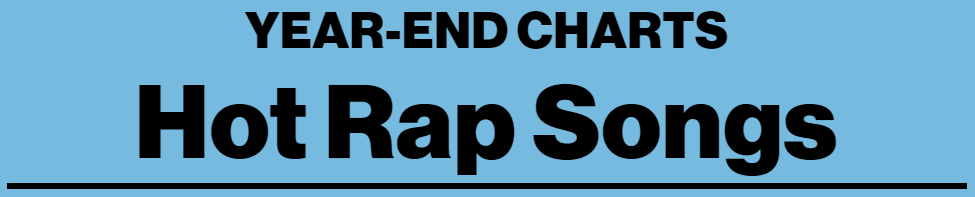

Zmiany 07.12.2022
* rozdzielenie funkcji scraping na scraping_to_dict (obsolete) i scraping_to_list, aby nie zagnieżdżać słownika: rok: artrysta: tytuł -> rok: artysta tytuł
* scraping z google - działa, ale należy rozszerzyć wynik (kliknięcie "pełny tekst")
* policzona częstotliwość występowania słów w dict_2013
---
- naprawić stop_words (głównie apostrofy)
- pełny tekst piosenek z google - OK
- do chmury słów wybrać tylko rzeczowniki i ew. czasowniki!

Zmiany 08.12.2022
* Import selenium do kliknięcia na przycisk "Full lyrics" (jeśl występuje) - funkcja w PyCharmie, wpisana w postaci tekstu do colaba'

Zmiany 11.12.2022
* Scrapowanie googla przez PyCharm - dict zapisany jako pickle, który należy zaimporować do colaba

Zmiany 15.12.2022
* ZAMIENIĆ liczbę wystąpień słów na liczbę unikalnych słów

#Libraries

In [67]:
from bs4 import BeautifulSoup as bs
import requests
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob, Word
# import time
from collections import Counter
import pandas as pd

In [4]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

#Scraping the billboard

##Loading the webpage (2013)

In [ ]:
r = requests.get('https://www.billboard.com/charts/year-end/2013/hot-rap-songs/')

##Converting to the beautiful soup object

In [ ]:
soup = bs(r.content, 'html.parser')

##Printing out the HTML code

In [ ]:
contents = soup.prettify()
print(contents[:100])

<!DOCTYPE html>
<!--[if IE 6]>
<html id="ie6" lang="en-US">
<![endif]-->
<!--[if IE 7]>
<html id="ie


##Finding the tags

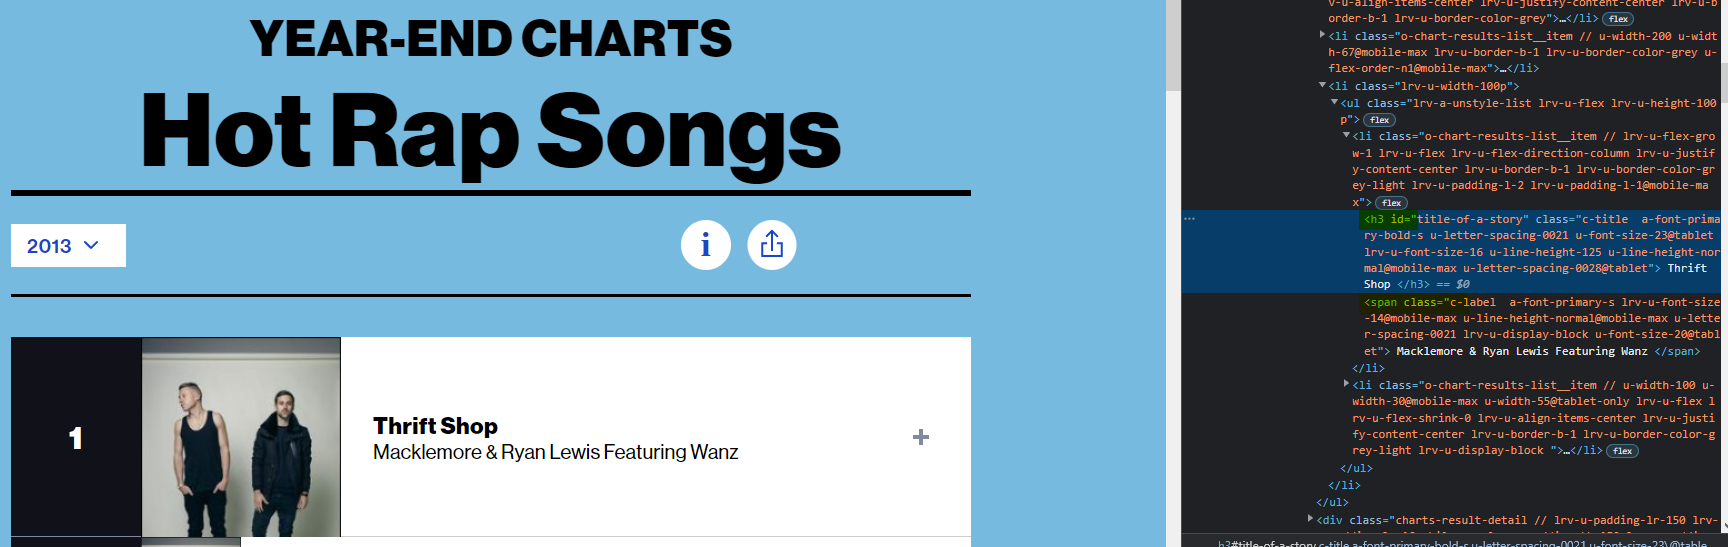

##Titles of the songs

In [ ]:
titles = []

for h3_tag in soup.find_all('h3')[:50]:
    titles.append(h3_tag.get_text(' ', strip = True))
    # print(h3_tag.get_text(' ', strip = True)) 

In [ ]:
titles[:3]

['Thrift Shop', "Can't Hold Us", 'Holy Grail']

##Artists

In [ ]:
artists = []

div_tag = soup.find('div', {'class': 'chart-results-list // u-padding-b-250'})
for li_tag in div_tag.find_all('li', {'class': 'lrv-u-width-100p'}):
  for span_tag in li_tag.find_all('span'):
    artists.append(span_tag.get_text(' ', strip = True))
    # print(span_tag.get_text(' ', strip = True))

In [ ]:
artists[:3]

['Macklemore & Ryan Lewis Featuring Wanz',
 'Macklemore & Ryan Lewis Featuring Ray Dalton',
 'Jay Z Featuring Justin Timberlake']

##Dict of artists and their songs

In [ ]:
songs_2013 = {}

for artist in artists:
  for song in titles:
    songs_2013[artist] = song
    # titles.remove(song)
    # break

In [ ]:
list(songs_2013.items())[:3]

[('Macklemore & Ryan Lewis Featuring Wanz', 'Pop That'),
 ('Macklemore & Ryan Lewis Featuring Ray Dalton', 'Pop That'),
 ('Jay Z Featuring Justin Timberlake', 'Pop That')]

#Scraping function

##Definition of the function

In [ ]:
def scraping_to_dict(url):
  r = requests.get(url)
  soup = bs(r.content)

  titles = []
  artists = []
  songs_dict = {}

  for h3_tag in soup.find_all('h3')[:50]:
    titles.append(h3_tag.get_text(' ', strip = True))

  div_tag = soup.find('div', {'class': 'chart-results-list // u-padding-b-250'})
  for li_tag in div_tag.find_all('li', {'class': 'lrv-u-width-100p'}):
    for span_tag in li_tag.find_all('span'):
      artists.append(span_tag.get_text(' ', strip = True))

  for artist in artists:
    for song in titles:
      songs_dict[artist] = song
      titles.remove(song)
      break

  return songs_dict

In [ ]:
def scraping_to_list(url):
  r = requests.get(url)
  soup = bs(r.content)

  titles = []
  artists = []
  songs_list = []

  #Titles
  for h3_tag in soup.find_all('h3')[:50]:
    titles.append(h3_tag.get_text(' ', strip = True))

  #Artists
  div_tag = soup.find('div', {'class': 'chart-results-list // u-padding-b-250'})
  for li_tag in div_tag.find_all('li', {'class': 'lrv-u-width-100p'}):
    for span_tag in li_tag.find_all('span'):
      artists.append(span_tag.get_text(' ', strip = True))

  songs_list = [x + ' ' + y for x, y in zip(artists, titles)]

  return songs_list

In [ ]:
# songs_2014 = scraping_to_list('https://www.billboard.com/charts/year-end/2014/hot-rap-songs/')
# songs_2014

##List of urls

In [ ]:
years = list(range(2013, 2023, 1))

base_url = 'https://www.billboard.com/charts/year-end/' #+year + end_url
end_url = '/hot-rap-songs/'

list_of_urls = []

for year in years:
  url = str(base_url + str(year) + end_url)
  list_of_urls.append(url)

In [ ]:
list_of_urls

['https://www.billboard.com/charts/year-end/2013/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2014/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2015/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2016/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2017/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2018/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2019/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2020/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2021/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2022/hot-rap-songs/']

##Dict of songs of the last 9 years

In [ ]:
dict_of_years = {}

for i in range(len(list_of_urls)):
  for year in years:
    dict_of_years[year] = scraping_to_dict(list_of_urls[i])
    # dict_of_years[year] = scraping_to_list(list_of_urls[i])

In [ ]:
songs_dict = {}
songs = {}

for year in years:
    songs_dict[year] = scraping_to_dict(list_of_urls[year - 2013])
    songs[year] = scraping_to_list(list_of_urls[year - 2013])

In [ ]:
list(songs.items())[-1]

(2022,
 ['Jack Harlow First Class',
  'Future Featuring Drake & Tems Wait For U',
  'Latto Big Energy',
  'Kodak Black Super Gremlin',
  'Lil Nas X & Jack Harlow Industry Baby',
  'Drake Featuring 21 Savage Jimmy Cooks',
  'Doja Cat Vegas',
  'Lil Baby In A Minute',
  'Gunna & Future Featuring Young Thug Pushin P',
  'Megan Thee Stallion & Dua Lipa Sweetest Pie',
  'Nicki Minaj Super Freaky Girl',
  'Drake Featuring 21 Savage & Project Pat Knife Talk',
  'Drake Featuring Future & Young Thug Way 2 Sexy',
  'Lil Durk Featuring Morgan Wallen Broadway Girls',
  'Lil Durk Featuring Gunna What Happened To Virgil',
  'Future Puffin On Zootiez',
  'Drake Featuring Lil Baby Girls Want Girls',
  'JNR CHOI & Sam Tompkins To The Moon!',
  'Drake Sticky',
  'Nardo Wick Featuring G Herbo, Lil Durk & 21 Savage Who Want Smoke??',
  'Yung Gravy Betty (Get Money)',
  'Post Malone Featuring Roddy Ricch Cooped Up',
  "Hitkidd & GloRilla F.N.F. (Let's Go)",
  'DJ Khaled Featuring Drake & Lil Baby Staying A

##Saving a dict with the pickle

In [ ]:
def to_pickle(file, filename):
  base_url = '/content/drive/MyDrive/Projekty/PROJEKT/'
  with open (base_url+filename, 'wb') as handle:
    pickle.dump(file, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
#Pickling the dict where key is the year and value is the list with songs
to_pickle(songs, 'songs.pickle')

In [ ]:
#Pickling the dict where key is the year and value is the dict with artist:song
# to_pickle(songs_dict, 'songs_dict.pickle')

In [ ]:
with open('/content/drive/MyDrive/Projekty/PROJEKT/songs.pickle', 'rb') as handle:
  songs = pickle.load(handle)

#Handling a specific year

In [ ]:
#Show songs from year 2013
songs[2022]

['Jack Harlow First Class',
 'Future Featuring Drake & Tems Wait For U',
 'Latto Big Energy',
 'Kodak Black Super Gremlin',
 'Lil Nas X & Jack Harlow Industry Baby',
 'Drake Featuring 21 Savage Jimmy Cooks',
 'Doja Cat Vegas',
 'Lil Baby In A Minute',
 'Gunna & Future Featuring Young Thug Pushin P',
 'Megan Thee Stallion & Dua Lipa Sweetest Pie',
 'Nicki Minaj Super Freaky Girl',
 'Drake Featuring 21 Savage & Project Pat Knife Talk',
 'Drake Featuring Future & Young Thug Way 2 Sexy',
 'Lil Durk Featuring Morgan Wallen Broadway Girls',
 'Lil Durk Featuring Gunna What Happened To Virgil',
 'Future Puffin On Zootiez',
 'Drake Featuring Lil Baby Girls Want Girls',
 'JNR CHOI & Sam Tompkins To The Moon!',
 'Drake Sticky',
 'Nardo Wick Featuring G Herbo, Lil Durk & 21 Savage Who Want Smoke??',
 'Yung Gravy Betty (Get Money)',
 'Post Malone Featuring Roddy Ricch Cooped Up',
 "Hitkidd & GloRilla F.N.F. (Let's Go)",
 'DJ Khaled Featuring Drake & Lil Baby Staying Alive',
 'SleazyWorld Go Featuri

In [ ]:
print(len(songs[2022]))

50


In [ ]:
#Dict_dict_of_years
# first_song = list(dict_dict_of_years[2013].items())[0]

#Dict_list_of_years
first_song = songs[2022][0]
first_song

'Jack Harlow First Class'

In [ ]:
#Necessary if dict_dict_of_years was used
# def tuple_to_str(row):
#   str = ' '.join(row)
#   return str

# first_song = tuple_to_str(first_song)
# first_song

###Exporting songs list to a pickle file and processing it with PyCharm

In [ ]:
to_pickle(songs[2013], 'songs_2013.pickle')

In [ ]:
for year in years:
  to_pickle(songs[year], f'songs_{year}.pickle')

##PyCharm script

```
import os
import pickle
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

os.environ['PATH'] += r"C:/Users/Arek/PycharmProjects/PROJEKT_studia/"

with open('songs_2022.pickle', 'rb') as handle:
    dict_list_of_years = pickle.load(handle)

def scraper(text):
    text = text.replace('&', '')
    text = text.replace('Featuring', '')
    base_url = 'https://google.com/search?q='
    url = base_url + str(text) + ' lyrics'

    driver = webdriver.Chrome()
    driver.get(url)
    driver.implicitly_wait(3)
    driver.find_element_by_xpath('//*[@id="L2AGLb"]/div').click()
    driver.implicitly_wait(3)

    try:
        l = driver.find_element_by_xpath(
            '//*[@id="kp-wp-tab-overview"]/div[2]/div/div/div[2]/div/div/div/div/div/div/div[1]/div[2]/div/a')
        if l.size() == 0:
            pass
        else:
            l.click()
    except:
        pass
    # .click()

    # Wait for 5 seconds
    WebDriverWait(driver, 5).until(
        EC.invisibility_of_element(
            (
            By.XPATH, '//*[@id="kp-wp-tab-overview"]/div[2]/div/div/div[2]/div/div/div/div/div/div/div[1]/div[2]/div/a')
        )
    )
    current_url = driver.current_url
    # print(str(driver.current_url))

    # After "Pełny tekst" was clicked
    page_source = driver.page_source
    # print(page_source)

    soup = bs(page_source, features='lxml')
    div_tags = soup.find_all('div', {'class': 'xaAUmb'})
    lyrics = []
    for div_tag in div_tags:
        lyrics.append(div_tag.get_text(' ', strip=True))

    return lyrics

songs = {}

for i in range(len(dict_list_of_years)):
    try:
        songs[dict_list_of_years[i]] = scraper(dict_list_of_years[i])
    except:
        songs[dict_list_of_years[i]] = []

def to_pickle(file, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(file, handle, protocol=pickle.HIGHEST_PROTOCOL)

to_pickle(songs, 'PyCharm_songs_2022.pickle')
```



#Natural Language Processing

---

##Loading the pickle created with PyCharm (dict of songs) to combine all lyrics in one list
---

In [5]:
with open('/content/drive/MyDrive/Projekty/PROJEKT/PyCharm_songs_2013.pickle', 'rb') as handle:
  songs_2013 = pickle.load(handle)

In [ ]:
list(songs_2013.values())

In [7]:
list_of_words_2013 = ''.join(str(list(songs_2013.values())))
list_of_words_2013

'[[\'Hey Macklemore? Can we go thrift shopping? What, what, what, what What, what, what, what What, what, what, what What, what, what, what What, what, what, what (bada, bada, bada doo da) What, what, what, what (bada, bada, bada doo da) What, what, what, what (bada, bada, bada doo da) What, what, what, what (bada, bada, bada doo da) oh oh (Bada, bada, bada doo da) (Bada, bada, bada doo da) ow I\\\'m gonna pop some tags Only got twenty dollars in my pocket I, I, I\\\'m hunting, looking for a come-up This is fucking awesome Nah walk up to the club like, what up, I got a big cock I\\\'m just pumped, just bought some shit from the thrift shop (oh) Ice on the fringe, it\\\'s so damn frosty The people like, "Damn! That\\\'s a cold ass honkey" Rollin\\\' in, hella deep, headin\\\' to the mezzanine Dressed in all pink, \\\'cept my gator shoes, those are green Draped in a leopard mink, girls standin\\\' next to me Probably shoulda washed this, smells like R. Kelly\\\'s sheets (Piss) But shit, 

##Removing special characters

In [ ]:
#Removing characters: [],"\ etc.
list_of_words_2013 = list_of_words_2013.translate({ord(i): None for i in '[],".\\()!?…'})
list_of_words_2013 = list_of_words_2013.replace("'", "",)
list_of_words_2013 = list_of_words_2013.replace("Coś się nie udało Spróbuj jeszcze raz Przetłumacz na: polski", " ")

##Uppercase to lowercase

In [ ]:
list_of_words_2013 = list_of_words_2013.lower()

##Removing stopwords

In [ ]:
stop_words = STOPWORDS #Removing unnecessary words
stop_words.update(["you'd", "i'd", "'ll", "'til", "'s", "ca n't", "n't", "'m", "'re", "y'all"])

print(stop_words)

{'because', 'from', 'those', 'there', 'few', 'further', 'until', 'against', 'does', 'itself', 'we', 'after', "there's", 'between', 'each', 'have', 'whom', "she'd", "didn't", 'no', 'why', 'your', "when's", 'through', 'our', 'can', "he'll", 'hence', 'too', "he'd", 'during', "she's", 'also', 'with', 'its', 'all', 'that', 'you', 'them', 'it', 'since', 'like', "they'll", 'yours', "can't", 'therefore', 'which', 'off', "mustn't", "isn't", 'than', 'however', "who's", 'such', 'by', 'into', 'she', 'under', "couldn't", 'am', "she'll", 'ourselves', 'her', "where's", 'do', 'most', "they've", 'r', 'ought', 'only', "we'd", 'being', 'had', "wouldn't", 'should', 'myself', 'as', "ca n't", 'here', "i'd", "that's", "doesn't", "'re", 'my', 'about', 'for', "we're", 'were', 'up', "we'll", 'yourself', 'same', 'herself', 'would', 'so', 'did', 'while', "why's", 'how', "let's", 'cannot', 'otherwise', 'i', 'where', 'both', 'then', "they're", "here's", "shouldn't", 'if', 'is', "'m", "he's", 'this', 'other', 'an', 

In [ ]:
words = word_tokenize(list_of_words_2013)
stripped_words = []
for word in words:
  if word not in stop_words:
    stripped_words.append(word)

print(" ".join(stripped_words))

stripped_words_str = " ".join(stripped_words)

hey macklemore go thrift shopping bada bada bada doo da bada bada bada doo da bada bada bada doo da bada bada bada doo da oh oh bada bada bada doo da bada bada bada doo da ow im gon na pop tags got twenty dollars pocket im hunting looking come-up fucking awesome nah walk club got big cock im pumped bought shit thrift shop oh ice fringe damn frosty people damn thats cold ass honkey rollin hella deep headin mezzanine dressed pink cept gator shoes green draped leopard mink girls standin next probably shoulda washed smells kellys sheets piss shit ninety-nine cents bag coppin washin bout go compliments passin moccasins someone elses walkin bummy grungy fuck man stuntin flossin savin money im hella happy thats bargain bitch ima take grandpas style ima take grandpas style real ask grandpa hand-me-downs thank velour jumpsuit house slippers dookie brown leather jacket found diggin broken keyboard bought broken keyboard bought skeet blanket bought kneeboard hello hello ace man mellow john wayne 

##Spell correction (TextBlob)

In [ ]:
corrected_words_str = TextBlob(stripped_words_str)
corrected_words_str = corrected_words_str.correct()

In [ ]:
corrected_words_str.sentiment

Sentiment(polarity=-5.7910384511129506e-05, subjectivity=0.5094516631484827)

##Noun pharases

In [ ]:
corrected_words_str.noun_phrases

##Lemmatization

In [ ]:
lemmatized_words = TextBlob(str(corrected_words_str))
lemmatized_words = " ". join([w.lemmatize() for w in lemmatized_words.words])

In [ ]:
lemmatized_words = lemmatized_words.split()

In [ ]:
corrected_words_str == lemmatized_words

False

##Extracting nouns only

In [ ]:
#Function to test if the word is a noun
is_noun = lambda pos: pos[:2] == 'NN'

tokenized = nltk.word_tokenize(corrected_words_str)
nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 

---
##Words processing function
---

In [45]:
def words_processing(pickled_list):
  list_of_words = ''.join(str(list(pickled_list.values())))
  #Removing special characters and removing phrase with polish words (last paragraph)
  # "$", ":", ".", "''", "'", ")", "(", ",", "``", "`", "[", "]"
  list_of_words = list_of_words.translate({ord(i): None for i in '[],".\\()!?…$`'})
  list_of_words = list_of_words.replace("'", "",)
  list_of_words = list_of_words.replace("Coś się nie udało Spróbuj jeszcze raz Przetłumacz na: polski", " ")

  #Changing all to lowercase
  list_of_words = list_of_words.lower()

  #Tokenizing
  words = word_tokenize(list_of_words)

  #Tagging
  tagged_words = nltk.pos_tag(words)

  #Spell correction with TextBlob / optionally
  # corrected_words = TextBlob(words)
  # corrected_words = corrected_words.correct()

  #Lemmatization
  lemmatized_words = TextBlob(str(words))
  lemmatized_words = " ". join([w.lemmatize() for w in lemmatized_words.words])
  lemmatized_words = lemmatized_words.split() #Back to list

  #Extracting nouns only with NLTK
  tagged_lem_words = nltk.pos_tag(lemmatized_words)
  is_noun = lambda pos: pos[:2] in ['NN', 'NNS', 'NNP', 'NNPS']
  nouns = [word for (word, pos) in tagged_lem_words if is_noun(pos)]

  #Extracting nouns only with TextBlob
  # nounsTextBlob = [word for (word, pos) in TextBlob(list_of_words).pos_tags if pos[0] == 'N']
  nounsTextBlob = [word for (word, pos) in TextBlob(str(lemmatized_words)).tags if pos[0] in ['NN', 'NNS', 'NNP', 'NNPS', 'RB']]

  #Removing stopwords continued
  stop_words = STOPWORDS #Removing necessary words
  stop_words.update(["you'd", "i'd", "'ll", "'til", "'s", "ca n't", "n't", "'m", "'re", "y'all", "am", "im", "em"])
  stripped_words = []
  for word in lemmatized_words:
    if word not in stop_words:
      stripped_words.append(word)
  stripped_words_str = " ".join(stripped_words)

  return nouns, tagged_words, lemmatized_words

In [10]:
with open('/content/drive/MyDrive/Projekty/PROJEKT/PyCharm_songs_2014.pickle', 'rb') as handle:
  songs_2014 = pickle.load(handle)

In [46]:
nouns, tagged_words, words_2014 = words_processing(songs_2014)
# words_2014

##Finding the most frequent word

In [ ]:
def count(word):
  # Check if the '.' is the last character of the word, if so, ignore it
  if word[-1] == '.':
      word = word[0:len(word) - 1]
  # If the word already exists in dict, increment the value
  if word in dictionary:
      dictionary[word] += 1
  # If the word doesn't apprear in the dict, create the key and assign value of 1
  else:
      dictionary.update({word: 1})

In [ ]:
dictionary = {}

for word in nouns:
    count(word)
 
for all_words in dictionary:
  if dictionary[all_words] >= 100:
    print ("Frequency of", all_words, end = " ")
    print (":", end = " ")
    print (dictionary[all_words], end = " ")
    # print()

Frequency of im : 247 Frequency of bitch : 127 Frequency of baby : 112 Frequency of dont : 130 Frequency of aint : 120 Frequency of hol : 142 

In [ ]:
dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))

##Counting verbs, nouns, and other parts of speech with python's NLTK

```
Parts of speech:
# 1.	CC	Coordinating conjunction
# 2.	CD	Cardinal number
# 3.	DT	Determiner
# 4.	EX	Existential there
# 5.	FW	Foreign word
# 6.	IN	Preposition or subordinating conjunction
# 7.	JJ	Adjective
# 8.	JJR	Adjective, comparative
# 9.	JJS	Adjective, superlative
# 10.	LS	List item marker
# 11.	MD	Modal
# 12.	NN	Noun, singular or mass
# 13.	NNS	Noun, plural
# 14.	NNP	Proper noun, singular
# 15.	NNPS	Proper noun, plural
# 16.	PDT	Predeterminer
# 17.	POS	Possessive ending
# 18.	PRP	Personal pronoun
# 19.	PRP$	Possessive pronoun
# 20.	RB	Adverb
# 21.	RBR	Adverb, comparative
# 22.	RBS	Adverb, superlative
# 23.	RP	Particle
# 24.	SYM	Symbol
# 25.	TO	to
# 26.	UH	Interjection
# 27.	VB	Verb, base form
# 28.	VBD	Verb, past tense
# 29.	VBG	Verb, gerund or present participle
# 30.	VBN	Verb, past participle
# 31.	VBP	Verb, non-3rd person singular present
# 32.	VBZ	Verb, 3rd person singular present
# 33.	WDT	Wh-determiner
# 34.	WP	Wh-pronoun
# 35.	WP$	Possessive wh-pronoun
```

In [47]:
#Checking tags of the first 20 words
tagged_words[:20]

[('first', 'RB'),
 ('things', 'NNS'),
 ('first', 'RB'),
 ('im', 'VBP'),
 ('the', 'DT'),
 ('realest', 'NN'),
 ('realest', 'NN'),
 ('drop', 'NN'),
 ('this', 'DT'),
 ('and', 'CC'),
 ('let', 'VB'),
 ('the', 'DT'),
 ('whole', 'JJ'),
 ('world', 'NN'),
 ('feel', 'VB'),
 ('it', 'PRP'),
 ('let', 'VB'),
 ('em', 'PRP'),
 ('feel', 'VB'),
 ('it', 'PRP')]

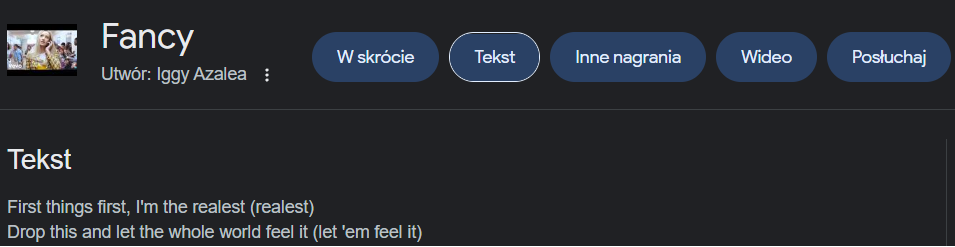

In [48]:
#Counting the parts of speech
counts = Counter(tag for word,tag in tagged_words)
counts

Counter({'RB': 1565,
         'NNS': 1051,
         'VBP': 1868,
         'DT': 2484,
         'NN': 6410,
         'CC': 662,
         'VB': 1728,
         'JJ': 2403,
         'PRP': 2363,
         'IN': 2897,
         'MD': 167,
         'RP': 428,
         'PRP$': 952,
         'PDT': 40,
         'VBD': 1008,
         'CD': 231,
         'WP': 207,
         'VBG': 420,
         'WRB': 227,
         'TO': 533,
         'VBZ': 501,
         'VBN': 373,
         'EX': 10,
         'RBR': 22,
         'WDT': 83,
         'JJR': 75,
         'FW': 168,
         ':': 6,
         'JJS': 28,
         '$': 1,
         'RBS': 4,
         'UH': 9,
         'WP$': 2,
         'NNP': 1})

In [66]:
#Normalizing the counts 
total = sum(counts.values())
dict((word, float(count)/total) for word,count in counts.items())

{'RB': 0.05410170429010959,
 'NNS': 0.036332837833166244,
 'VBP': 0.06457634735714039,
 'DT': 0.08587133128219311,
 'NN': 0.2215922840253051,
 'CC': 0.02288519376361185,
 'VB': 0.05973657828326477,
 'JJ': 0.08307117917516507,
 'PRP': 0.08168838801120061,
 'IN': 0.10014865005012617,
 'MD': 0.0057731531095516295,
 'RP': 0.014795865454419747,
 'PRP$': 0.0329104297023542,
 'PDT': 0.0013827911639644622,
 'VBD': 0.034846337331904446,
 'CD': 0.00798561897189477,
 'WP': 0.007155944273516093,
 'VBG': 0.014519307221626854,
 'WRB': 0.007847339855498323,
 'TO': 0.01842569225982646,
 'VBZ': 0.01731945932865489,
 'VBN': 0.01289452760396861,
 'EX': 0.00034569779099111555,
 'RBR': 0.0007605351401804543,
 'WDT': 0.002869291665226259,
 'JJR': 0.0025927334324333667,
 'FW': 0.005807722888650742,
 ':': 0.00020741867459466934,
 'JJS': 0.0009679538147751236,
 '$': 3.4569779099111554e-05,
 'RBS': 0.00013827911639644621,
 'UH': 0.000311128011892004,
 'WP$': 6.913955819822311e-05,
 'NNP': 3.4569779099111554e-05

#Creating the dataset

Year | Artist | Song | Parts of speech (35 cols) | most frequent words (top 5)

In [139]:
TEXT = ["First things first, I'm the realest (realest) Drop this and let the whole world feel it (let 'em feel it) And I'm still in the Murda Bizness I can hold you down, like I'm givin' lessons in physics (right, right?) You should want a bad bitch like this (ha?) Drop it low and pick it up just like this (yeah) Cup of Ace, cup of Goose, cup of Cris High heels, somethin' worth a half a ticket on my wrist (on my wrist) Takin' all the liquor straight, never chase that (never) Rooftop like we bringin' '88 back (what?) Bring the hooks in, where the bass at? Champagne spillin', you should taste that I'm so fancy You already know I'm in the fast lane From L.A. to Tokyo I'm so fancy Can't you taste this gold? Remember my name, 'bout to blow-oh-oh-oh I said, baby, I do this, I thought that you knew this Can't stand no haters and honest, the truth is And my flow retarded, each beat dear, departed Swagger on stupid, I can't shop at no department And get my money on time, if they not money, decline And swear I meant that there so much that I give that line a rewind Said I get my money on time, if they not money, decline I just can't worry 'bout no haters, gotta stay on my grind Now tell me, who that, who that? That do that, do that? Put that paper over all, I thought you knew that, knew that I be that I-G-G-Y, put my name in bold I been working, I'm up in here with some change to throw I'm so fancy You already know I'm in the fast lane From L.A. to Tokyo I'm so fancy Can't you taste this gold? Remember my name, 'bout to blow-oh-oh-oh Trash the hotel Let's get drunk on the minibar Make the phone call Feels so good getting what I want Yeah, keep on turning it up Chandelier swinging, we don't give a fuck Film star, yeah, I'm deluxe Classic, expensive, you don't get to touch, ow Still stunting, how you love that? Got the whole world asking how I does that Hot girl, hands off, don't touch that Look at it, I bet you wishing you could clutch that That's just the way you like it, huh? It's so good, he's just wishing he could bite it, huh? Never turn down nothin' Slaying these hoes, gold trigger on the gun like I'm so fancy You already know I'm in the fast lane From L.A. to Tokyo I'm so fancy Can't you taste this gold? Remember my name, 'bout to blow-oh-oh-oh Who that, who that, I-G-G-Y That do that, do that, I-G-G-Y Who that, who that, I-G-G-Y (Blow-oh-oh-oh) Who that, who that, I-G-G-Y That do that, do that, I-G-G-Y Who that, who that, I-G-G-Y (Blow-oh-oh-oh)"]

parts_of_speech = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH',
                     'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$']

def counting_pos(lyrics):
  counts_dict = {}
  for pos in parts_of_speech:
    values = Counter(tag for word,tag in nltk.pos_tag(str(lyrics).split()) if tag == pos)
    for count in values.values():
      counts_dict[pos] = count
  return counts_dict

In [140]:
counting_pos(TEXT)

{'CC': 7,
 'DT': 38,
 'EX': 1,
 'IN': 45,
 'JJ': 29,
 'JJR': 2,
 'JJS': 1,
 'MD': 5,
 'NN': 73,
 'NNS': 10,
 'NNP': 70,
 'PDT': 1,
 'PRP': 41,
 'PRP$': 10,
 'RB': 26,
 'RP': 4,
 'TO': 8,
 'VB': 30,
 'VBD': 13,
 'VBG': 6,
 'VBN': 2,
 'VBP': 38,
 'VBZ': 7,
 'WP': 7}

In [114]:
dfx = pd.DataFrame(counting_pos(TEXT), index = [1])

In [115]:
dfx

,CC,DT,EX,IN,JJ,JJR,JJS,MD,NN,NNS,...,RB,RP,TO,VB,VBD,VBG,VBN,VBP,VBZ,WP
1,7,38,1,45,29,2,1,5,73,10,...,26,4,8,30,13,6,2,38,7,7


In [146]:
parts_of_speech = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH',
                     'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$']

df_cols = ['Year', 'Artist', 'Song'] + parts_of_speech

def create_row(pickled_list):
  df = pd.DataFrame()
  #------------------------
  #Łączenie dfów? jeden z year, art, song, drugi z PoS
  #------------------------
  for item in pickled_list.items():
    row = pd.DataFrame(counting_pos(item[1]), index = [item[0]])
    df = df.append(row)

  return df

In [147]:
df = create_row(songs_2014)

In [148]:
df

,CC,DT,EX,IN,JJ,JJR,JJS,MD,NN,NNS,...,VBZ,WP,CD,FW,POS,WDT,RBR,NNPS,WP$,UH
Iggy Azalea Featuring Charli XCX Fancy,7.0,38.0,1.0,45.0,31.0,2.0,1.0,5.0,78,10.0,...,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pitbull Featuring Ke$ha Timber,6.0,35.0,NaN,19.0,26.0,15.0,NaN,NaN,88,1.0,...,3.0,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
Eminem Featuring Rihanna The Monster,27.0,48.0,NaN,72.0,57.0,1.0,NaN,4.0,122,19.0,...,10.0,5.0,6.0,NaN,1.0,2.0,NaN,NaN,NaN,NaN
Iggy Azalea Featuring Rita Ora Black Widow,18.0,25.0,NaN,63.0,32.0,3.0,NaN,NaN,94,6.0,...,12.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
Nicki Minaj Anaconda,10.0,29.0,NaN,71.0,61.0,1.0,NaN,4.0,124,8.0,...,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kid Ink Featuring Chris Brown Show Me,13.0,45.0,NaN,82.0,49.0,NaN,NaN,4.0,139,10.0,...,18.0,15.0,7.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN
Bobby Shmurda Hot Boy,15.0,38.0,NaN,56.0,43.0,NaN,NaN,1.0,107,16.0,...,4.0,5.0,2.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN
Becky G Shower,12.0,30.0,2.0,48.0,44.0,6.0,NaN,1.0,62,8.0,...,6.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
YG Featuring Jeezy & Rich Homie Quan My Hitta,17.0,43.0,NaN,76.0,33.0,NaN,NaN,NaN,206,26.0,...,6.0,2.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Rich Gang Featuring Young Thug & Rich Homie Quan Lifestyle,20.0,72.0,NaN,74.0,41.0,NaN,NaN,5.0,106,26.0,...,12.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
